# Debiasing with Orthogonalization

Previously, we saw how to evaluate a causal model. By itself, that's not an easy task. Causal models estimates the elasticity \\(\frac{\delta y}{\delta t}\\), which is an unseen quantity. Hence, since we can't see the groud truth of what our model is estimating, we had to be a little bit creative in how we would go about evaluating them. 

The technique shown on the previous chapter relied heavely on data where the treatment was randomly assigned. The idea was to estimate the elasticity \\(\frac{\delta y}{\delta t}\\) as the coeficiente of a single variable linear regression of `y ~ t`. However, this only works if the treatment is randomly assigned. If it isn't, we get into trouble due to omitted varibale bias. 

To workaround this, need to make data look as if the treatment is randomly assigned. I would say there are two main techiques to do this. One is using propensity score and the other using orthogonalization. We will cover the latter in this chapter.

One final word of caution before we continue. I would argue that probably the safest way out of non random data is to go out and do some sort of experiment to gather random data. I myself don't trust very much on debiasing techiques because you can never know if you've accounted for every counfounder. Having said, that orthogonalization is still very much worth learning. It's an incredibly powerfull technique that will be the foundation of many causal models to come. 

## Linear Regression Reborn

The idea of orthogonalization is based on a theorem designed by three econometricians in 1933, Ragnar Frisch, Frederick V. Waugh, and Michael C. Lovell. Simply put, it states that you can decompose any multivariable linear regression model into three satges or models. Let's say that your features are in an \\(X\\) matrix. Now, you partition that matrix somewhow in such a way that you get one part, \\(X_1\\), with some of the features and another part, \\(X_2\\), with the rest of the features. 

In the first stage, we take the first set of features and estimate the folowing linear regression model 

$$
y_i = \theta_0 + \pmb{\theta_1 X}_{1i} + e_i
$$

where \\(\pmb{\theta_1}\\) is a vector of parameters. We then take the residuals of that model

$$
y^* = y_i - (\hat{\theta}_0 + \pmb{\hat{\theta}_1 X}_{1i})
$$

On the seccond stage, we take the first set of features again, but now we run a model where we estimate the second set of features

$$
\pmb{X}_{2i} = \gamma_0 + \pmb{\gamma_1 X}_{1i} + e_i
$$

Here, we are using the first set of features to predict the seccond set of features. Finally, we also take the residuals for this second stage.

$$
\pmb{X}^*_{2i} = \pmb{X}_{2i} - (\hat{\gamma}_0 + \pmb{\hat{\gamma}_1 X}_{1i})
$$


Lastly, we take the residuals from the first and second stage, and run the estimate the following model

$$
y^* = \beta_0 + \pmb{\beta_2 X}^*_{2i} + e_i
$$

The Frisch–Waugh–Lovell theorem states that the parameter estimate \\(\pmb{\hat{\beta}_2}\\) from estimating this model is equivalent to the one we get by runing the regression with all the features

$$
y_i = \beta_0 + \pmb{\beta_1 X}_{1i} + \pmb{\beta_2 X}_{2i} + e_i
$$

It's hard to apreciate how awsome this is. But remember what this last complete linear regression is doing. It is estimating the impact of \\(X_2\\) on \\(y\\) while accounting for \\(X_1\\). This is incredebly powerfull for causal inference. It says that I can build a model that predicts my treatment \\(t\\) using my features \\(X\\), a model tha predicts the outcome \\(y\\) using the same features, take the residuals from both models and run a model that estimates how the residual of \\(t\\) affects the residual of \\(y\\). This last model will tell me how \\(t\\) affects \\(y\\) while controling for \\(X\\). There is (not so complicated) mathematical proof for why that is the case, but I think the intuition behind this theorem is so straighforeward we can go direcly into it.

## The Intuition Behind Orthogonalization

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
import statsmodels.api as sm

from nb21 import cumulative_elast_curve_ci, elast, cumulative_gain_ci

Let's take our price data once again. But now, we will only take the sample where prices where **not** randomly assigned. Once again, we separate them into a training and a test set. Since we will use the test set to evaluate our causal model, let's see how we can we use othogonalization to debias it. 

In [2]:
prices = pd.read_csv("./data/ice_cream_sales.csv")

train, test = train_test_split(prices, test_size=0.5)
train.shape, test.shape

((5000, 5), (5000, 5))

If we show the correlations on the test set, we can see that price is positively correlated with sales, meaning that sales should go up as we increase prices. This is obviously nonsense. We probably have some sort of bias here. 

In [3]:
test.corr()

,temp,weekday,cost,price,sales
temp,1.000000,0.004353,0.002619,-0.003144,0.394469
weekday,0.004353,1.000000,0.006229,0.015650,0.010065
cost,0.002619,0.006229,1.000000,0.383971,-0.007942
price,-0.003144,0.015650,0.383971,1.000000,0.077656
sales,0.394469,0.010065,-0.007942,0.077656,1.000000


If we plot our data, we can see why this is happening. Weekends (Saturday and Sunday) have higer price but also higher sales. We can see that this is the case because the weekend cloud of points seems to be to the right upper part of the plot.

Weekend is probably playng an important role in the bias here. On the weekends, there are more icecream sales because there is more demand. In response to that demand, prices go up. So it is not that increase in price causes sales to go up. It is just that both sales and prices are high on weekends. 

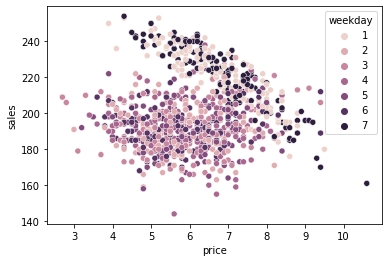

In [4]:
np.random.seed(123)
sns.scatterplot(data=test.sample(1000), x="price", y="sales", hue="weekday");

To debias this dataset we will need to models. The first model, let's call it \\(M_t(X)\\), predicts the treatment (price, in our case) using the confounders. It's the one of the stages we've seen above, on the Frisch–Waugh–Lovell theorem.

In [5]:
m_t = smf.ols("price ~ cost + C(weekday) + temp", data=test).fit()
debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test)})

Once we have this model, we will construct the residuals

$$
\hat{t}_i = t_i - M_t(X_i)
$$

You can think of this residual as a version of the treatment that is unbiased or, better yet, that is inpossible to predict from the confounders \\(X\\). Since the confounders where already used to predict \\(t\\), the residual is by definition, unpredictable with \\(X\\). Another way of saying this is that the bias have been explained away by the model \\(M_t(X_i)\\), prudicing \\(\hat{t}_i\\) wich is as good as randomly assigned. Of course this only works if we have in \\(X\\) all the confounders that causes both \\(T\\) and \\(Y\\)

We can also plot this data to see what it looks like.

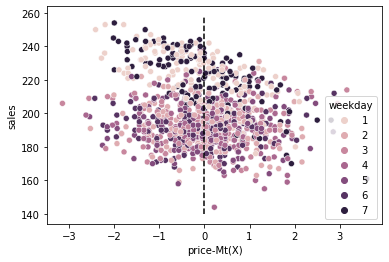

In [6]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales", hue="weekday")
plt.vlines(0, debiased_test["sales"].min(), debiased_test["sales"].max(), linestyles='--', color="black");

We can see that the weekends are no longer to the upper right cornr. They got pushed to the center. As we can see, we can no longer diferentiate between differen price levels (the treatment) using the weekdays. We can say that the residual \\(price-M_t(X)\\), ploted on the x-axis, is a "random" or debiased version of the original treatment.

This alone is suficient to debias the dataset. This new treatment we've creates is as good as randomly assigned. But we can still do one other thing to make the debiased dataset even better. Namely, we can also construct residuals for the outcome.

$$
\hat{y}_i = y_i - M_y(X_i)
$$

This is another stage from the Frisch–Waugh–Lovell theorem. It doesn't make the set less biased, but it makes it easier to estimate the elasticity by reducing the variance in \\(y\\). Once again, you can think about \\(\hat{y}_i\\) as a version of \\(y_i\\) that is unpredictable from \\(X\\) or that had all its variances due to \\(X\\) explained away. If that is the case, the only thing left to explain \\(\hat{y}_i\\) is something we didn't used to construct it (not included in \\(X\\)), wich is only the treatment (again, assuming no unmeasured confounders). 

In [7]:
m_y = smf.ols("sales ~ cost + C(weekday) + temp", data=test).fit()

debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test),
                               "sales-My(X)":test["sales"] - m_y.predict(test)})

Once we do both transformation, not only weekday does not predict thre price residuals, but it also can't predict the residual of sales \\(\hat{y}\\). The only think left to predict this residual is the treatment. Also, notice something interesting. In the plot above, it was hard to know the direction of the price elasticity. It looked like sales decreased as as prices went up, but there whas such a large variance in sales that it was hard to say that for sure. 

Now, when we plot the two residuals, it becomes much clear that sales indeed causes prices to go down.

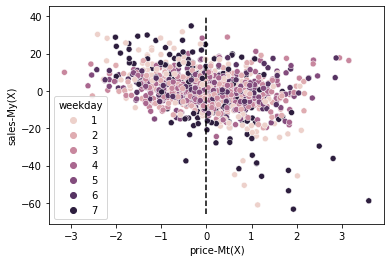

In [8]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales-My(X)", hue="weekday")
plt.vlines(0, debiased_test["sales-My(X)"].min(), debiased_test["sales-My(X)"].max(), linestyles='--', color="black");

One small disadvantage of this debiased data is that the residuals have been shifted to a different scale. As a result, its hard to interpet what they mean (what is a price residual of -3?). Still, I think this is a small price to pay for the convinience of building random data from data that was not initially random. 


To summarize, by predicting the treatment, we've constructed \\(\hat{t}\\) which works as an unbiased version of the treatment; by predicting the outcome, we've contructed \\(\hat{y}\\) wich is a version of the outcome that is only explained by the treatment. This data, where we replace \\(y\\) by \\(\hat{y}\\) and \\(t\\) by \\(\hat{t}\\) is the debiased data we wanted. We can use it to evaluate our causal model just like we deed previously using random data.

To see this, let's once again build a causal model for price elasticity using the train data.

In [9]:
m3 = smf.ols(f"sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

Then, we'll make elasticity predictions on the debiased test set.

In [10]:
def predict_elast(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

debiased_test_pred = debiased_test.assign(**{
    "m3_pred": predict_elast(m3, debiased_test),
})

debiased_test_pred.head()

,temp,weekday,cost,price,sales,price-Mt(X),sales-My(X),m3_pred
6109,21.4,6,1.0,6.2,189,0.153911,1.972445,0.017303
6201,11.1,4,1.0,7.3,140,1.228951,-27.239070,3.723173
8068,26.0,3,1.5,6.9,206,0.459689,11.006580,-1.395817
1802,23.7,5,1.5,6.2,200,-0.333667,9.522241,-0.446765
5053,23.7,2,0.3,5.6,184,0.266517,-7.366641,0.552819


Now, when it comes to ploting the cummulative elasticity, we still order the dataset by the predictive elasticity, but now we use the debiased versions of the treatment and outcome to get this elasticity. This is equivalent to estimating \\(\beta_1\\) in the folowing regression model

$$
\hat{y}_i = \beta_0 + \beta_1 \hat{t}_i + e_i
$$

where the residuals have been made like we've described before.

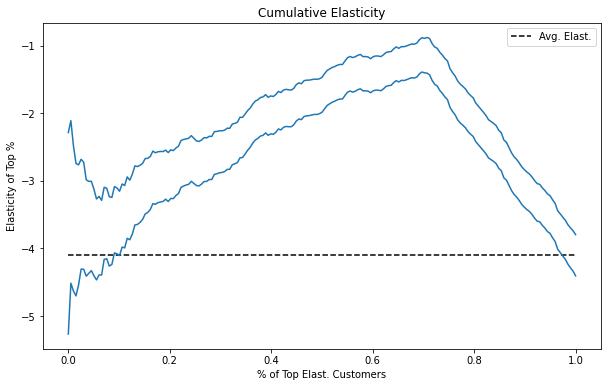

In [11]:
plt.figure(figsize=(10,6))

cumm_elast = cumulative_elast_curve_ci(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_elast)))
plt.plot(x/x.max(), cumm_elast, color="C0")

plt.hlines(elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Elasticity of Top %")
plt.title("Cumulative Elasticity")
plt.legend();

We can do the same thing for the cumulative gain curve, of course.

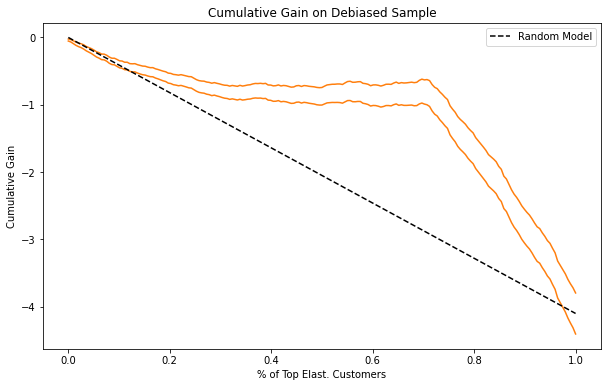

In [12]:
plt.figure(figsize=(10,6))

cumm_gain = cumulative_gain_ci(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, color="C1")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain on Debiased Sample")
plt.legend();

Notice how similar these plots looks to the ones in the previous chapter. This is some indication that the debiasing worked wonders here. 

In contrast, let's see what the cumulative gain plot would look like if we used the original, biased data.

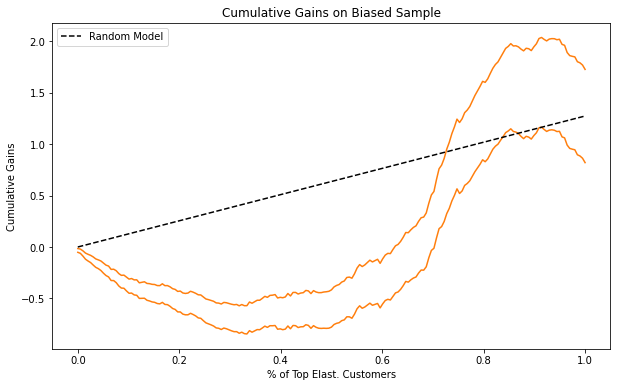

In [13]:
plt.figure(figsize=(10,6))

cumm_gain = cumulative_gain_ci(debiased_test_pred, "m3_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, color="C1")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.title("Cumulative Gains on Biased Sample")
plt.ylabel("Cumulative Gains")
plt.legend();

First thing you should notice is that the average elasticity goes up, insetad of down. We've seen this before. In the biased data, it looks like sales goes up as price increases. As a result, the final point in the cumulative gain plot is positive. This makes little sense, since we now people don't buy more as we increase icecream prices. If the average price elasticity is already messed up, any ordering in it also makes little sense. The bottom line being that this should not be used for model evaluation.

## Orthogonalization with Machine Learning

In a 2016 paper, Victor Chernozhukov *et all* showed that you can also do orthogonalization with machine learning models. This is obviously very recent science and we still have much to discover on what we can and can't do with ML models. Still, it's a very interesting idea to know about.

The nuts and bolts are pretty much the same to what we've already covered. The only diference is that now, we use machine learning models for the debiasing. 

$$
\begin{align}
\hat{y}_i &= y_i - M_y(X_i) \\
\hat{t}_i &= t_i - M_t(X_i)
\end{align}
$$

There is a catch, though. As we know very well, machine learning models are so powerfull that they can fit the data perfectly, or rather, overfit. Just by looking at the equations above, we can know what will hapen. If \\(M_y\\) somehow overfitts, the residuals will be all very close to zero. If that happen, it will be hard to find how \\(t\\) afects it. Similarly, if \\(M_y\\) somehow overfitts, its residuals will all be close to zero. Hence, there won't be variation in the treatment residual to see how it can impact the outcome. 

To account for that, we need to do sample splitting. That is, we estimate the model with one part of the dataset and we make predictions in the other part. The simplest way to do this is to simply split the test sample in half, make two models that each one is estimated in one half and makes predictions in the other. 

A sligly more elegant implementation uses K-fold cross validation. The advantage being that we can train each model on a sample which is bigger than half the test set.

![img]()



In [14]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

X = ["cost", "weekday", "temp"]
t = "price"
y = "sales"

t_hats = []
y_hats = []

kf = KFold(n_splits=5)

np.random.seed(42)
for est, pred in kf.split(test):

    ## train M_t model and get treatment residuals
    m_t = RandomForestRegressor(n_estimators=100).fit(test.iloc[est][X],test.iloc[est][t])
    t_hat = test.iloc[pred][t] - pd.Series(m_t.predict(test.iloc[pred][X]), 
                                           index=test.iloc[pred].index)
    
    ## train M_y model and get outcome residuals
    m_y = RandomForestRegressor(n_estimators=100).fit(test.iloc[est][X],test.iloc[est][y])
    y_hat = test.iloc[pred][y] - pd.Series(m_y.predict(test.iloc[pred][X]),
                                           index=test.iloc[pred].index)
    
    t_hats += [t_hat]
    y_hats += [y_hat]

This implementation relies on pandas indexing. We will make preadictions on each k-fold of the test sent and put everything together with pandas `concact` function. This only works because all the predictions are properly indexed.

In [15]:
ml_debiased_test = test.assign(**{
    "sales-ML_y(X)": pd.concat(y_hats),
    "price-ML_t(X)": pd.concat(t_hats),
})

ml_debiased_test.head()

,temp,weekday,cost,price,sales,sales-ML_y(X),price-ML_t(X)
6109,21.4,6,1.0,6.2,189,1.932833,1.102833
6201,11.1,4,1.0,7.3,140,-19.200000,1.585000
8068,26.0,3,1.5,6.9,206,0.680000,0.326905
1802,23.7,5,1.5,6.2,200,5.291500,0.047983
5053,23.7,2,0.3,5.6,184,0.235365,0.142083


Finally, we can plot the results.

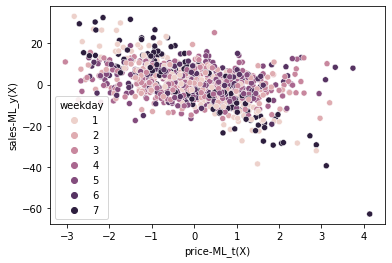

In [16]:
np.random.seed(123)
sns.scatterplot(data=ml_debiased_test.sample(1000),
                x="price-ML_t(X)", y="sales-ML_y(X)", hue="weekday");

## Key Ideas



## References 

The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.

This chapter is based on Victor Chernozhukov *et all* (2016), Double/Debiased Machine Learning for Treatment and Causal Parameters. You can also check Frisch, Ragnar; Waugh, Frederick V. (1933) orginal article, Partial Time Regressions as Compared with Individual Trends. 

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).